# Stock Price Forcasting Using Tensorflow

In [94]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Miscellaneous Functions

In [95]:
def drop_columns(hist):
    return hist.drop(columns=['High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

def set_size(num, df):
    return df.shape[0]-num

In [96]:
## Collecting the data

In [97]:
data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
n = len(df)
df

,Open,Close
Date,,
2010-01-04,23.91,24.17
2010-01-05,24.09,24.18
2010-01-06,24.11,24.03
2010-01-07,23.92,23.78
2010-01-08,23.65,23.94
...,...,...
2020-09-17,200.05,202.91
2020-09-18,202.80,200.39
2020-09-21,197.19,202.54


In [98]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,2700.0,61.062748,47.745481,18.20,24.5750,41.57,85.2275,229.27
Close,2700.0,61.080204,47.752359,18.13,24.6075,41.65,84.8575,231.65


In [99]:
import datetime

date_time = pd.to_datetime(df.index, format='%d.%m.%Y')
timestamp_s = date_time.map(datetime.datetime.timestamp)
date_time

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-10', '2020-09-11', '2020-09-14', '2020-09-15',
               '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-21',
               '2020-09-22', '2020-09-23'],
              dtype='datetime64[ns]', name='Date', length=2700, freq=None)

In [100]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'Open': 0, 'Close': 1}

## Splitting the data

In [101]:
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalizing the data using regularization

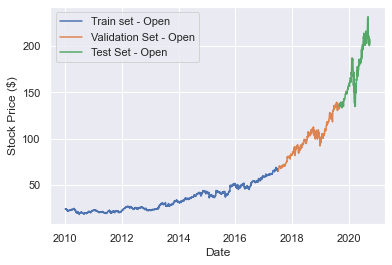

In [102]:
plt.plot(train_df['Close'])
plt.plot(val_df['Close'])
plt.plot(test_df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(['Train set - Open', 'Validation Set - Open', 'Test Set - Open'])
plt.show()

In [103]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
val_df = (train_df - train_mean)/train_std
test_df = (train_df - train_mean)/train_std

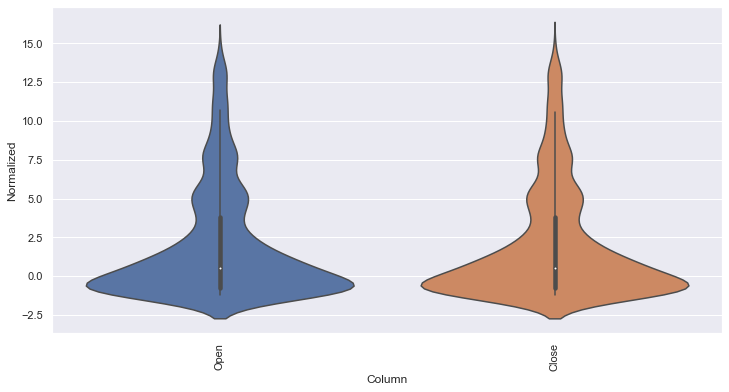

In [104]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [105]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [106]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['Close'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Close']

In [107]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['Close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Close']

In [108]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [109]:
import tensorflow as tf

# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 2)
labels shape: (3, 1, 1)


In [110]:
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

WindowGenerator.plot = plot

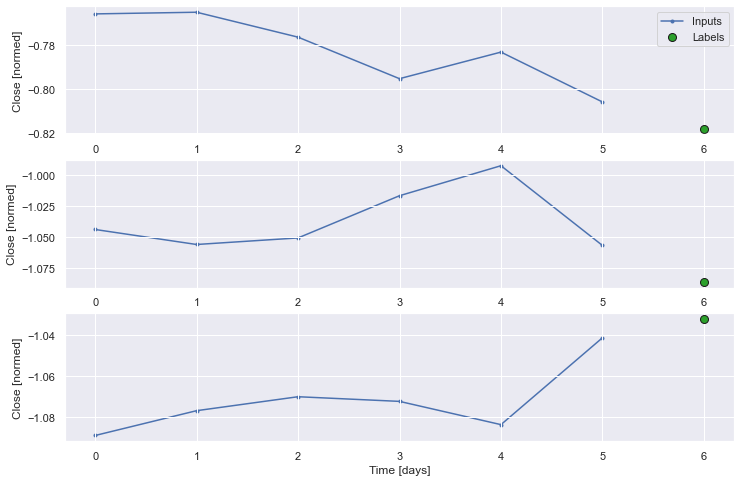

In [111]:
w2.plot()

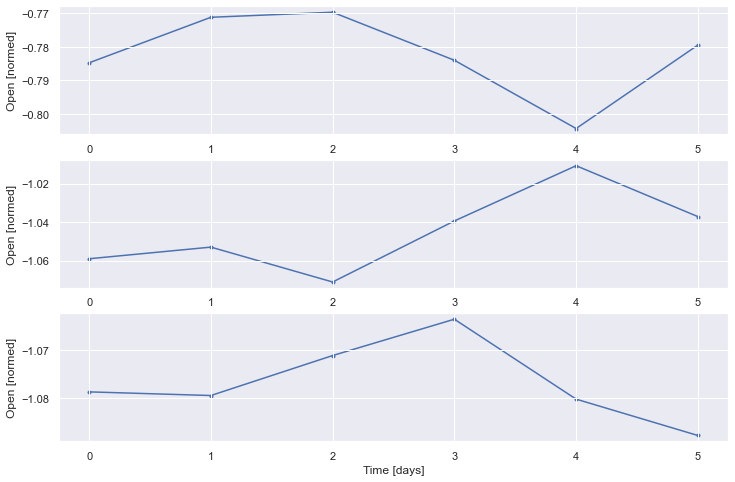

In [112]:
w2.plot(plot_col='Open')

In [113]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [114]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [115]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [116]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models 